# Team members: 
Anqi Chen, Wenyun Wang, Hanyue Wang

# References:
- "Time Series Analysis with Applications in R" by Jonathan D. Cryer and Kung-Sik Chan

- https://docs.pymc.io/en/v3/pymc-examples/examples/time_series/AR.html

- https://en.wikipedia.org/wiki/Autoregressive_model


In [1]:
import condensate_speckle
from condensate_speckle.data_io import get_example_data_file_path, load_data
from condensate_speckle.inference.model import set_model

# General model & simulating data

We are using first order autoregression model as our general model. The overal general form of autoregression model is $Y_t=\sum_{i=1}^{p}\phi_i\times Y_{t-i}+e_t$, where $Y$ is the intensity at each time point, $\phi_i$ is the decay parameter that depends on $\tau$, and $e_t$ is the innovation term. For this project, we are using first-order approximation only, known as AR(1) model. That is $$Y_t=\phi\times Y_{t-1}+e_t$$
, where $\phi=\exp(-1/\tau)$. So the equation becomes $Y_t=\exp(-1/\tau)\times Y_{t-1}+e_t$. 

We need to specify three variables in order to build the generative model: the mean $c$ and standard deviation $\sigma_e$ of the innovation term $e_t$, and decay time $\tau$. Here, $e_t$ is considered as Gaussian distribution and $\tau$ is the value that we are most interested in. We also need the distribution noise level of microscope, which is assumed to be a Normal distribution as well.

From the model, the overall data intensity mean can be calculated by $\frac{c}{1-\phi}$ and the intensity variance is $\frac{\sigma_e^2}{1-\phi^2}$. 

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pymc3 as pm
import arviz as az
import statsmodels.api as sm
import csv

/Users/Hanyue/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [3]:
X = load_data('[110, 145]_intensity.csv',data_dir='condensate_speckle/example_data').to_numpy()

/Users/Hanyue/Documents/GitHub/Condensate_speckles/condensate_speckle/example_data/[110, 145]_intensity.csv


In [4]:
X

array([[0.00000000e+00, 5.30973451e-02, 1.06194690e-01, ...,
        4.76283186e+01, 4.76814159e+01, 4.77345133e+01],
       [9.58484628e+01, 8.03959162e+01, 9.84004757e+01, ...,
        1.11364771e+02, 9.51213351e+01, 8.99137043e+01]])

In [5]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 10787
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# Fitting simulated data with pymc3 AR(1) model

To fit our model AR1 model, we want to extract the following parameters: decay time, which is the $\tau$ above; stationary is the $\phi$, precision is defined as $\frac{1}{\sigma_e^2}$; center is the innovation mean. Our prior for $\tau$ is uniform from 0 to 50, based on the experimental data time scale; for precision, we also use a uniform prior from 0 to 10 times the calculated precision from simulation parameters; for center, it is uniform from the lowest possible intensity to the highest possible intensity.

Thus, the statistical model we use is:
$$ \tau \sim \text{Uniform} (0,50) $$
$$ \text{precision} \sim \text{Uniform} (0, 1) $$
$$ \mu \sim \text{Uniform} (I_{min}, I_{max}) $$
$$ p(X) \sim \text{AR1} (\text{k} = e^{-1/\tau}, \text{tau_e} = \text{precision}, \text{observed} = X-\mu )$$

In [7]:
quantization = 255
ar1_model=set_model(X[1],quantization)

In [8]:
estimate = pm.find_MAP(model = ar1_model)

In [9]:
estimate

{'decay_time_interval__': array(11.5130019),
 'precision_interval__': array(86.67166141),
 'y': array([ 8.52911835e+00,  8.74805586e+00,  9.22412193e+00,  9.72590270e+00,
         1.02332071e+01,  1.07763444e+01,  1.13125482e+01,  1.15115819e+01,
         1.15319000e+01,  1.14058603e+01,  1.11169292e+01,  1.08591911e+01,
         1.05358487e+01,  1.00763588e+01,  9.59034273e+00,  9.06235745e+00,
         8.40515522e+00,  7.40297645e+00,  6.42136970e+00,  5.66749757e+00,
         5.16992735e+00,  4.14297902e+00,  3.11580989e+00,  2.18039982e+00,
         1.28028698e+00,  3.91267070e-01, -1.86616068e-01, -7.47426064e-01,
        -1.30841244e+00, -1.65302670e+00, -1.88053597e+00, -2.33406311e+00,
        -3.00809110e+00, -3.61728443e+00, -4.05045610e+00, -4.34023020e+00,
        -4.45905087e+00, -4.61682558e+00, -4.66584802e+00, -4.83387877e+00,
        -5.01151398e+00, -5.01291619e+00, -4.80352549e+00, -4.71705568e+00,
        -4.64638443e+00, -4.58182269e+00, -4.68850840e+00, -4.6776168

In [10]:
with ar1_model:
    trace = pm.sample(1000, tune=2000, init="advi+adapt_diag", random_seed=RANDOM_SEED)
    idata = az.from_pymc3(trace)

/var/folders/7g/r91p7_3s5ms7npzg4qybv9680000gn/T/ipykernel_5462/137214802.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=2000, init="advi+adapt_diag", random_seed=RANDOM_SEED)
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 3,585.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y, precision, decay_time]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 27 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [ ]:
# A probabilistic generator for tao
tao = 10
phi = np.exp(-1/tao)

camera_noise_mean = 5
camera_noise_std = 1

intensity_mean = 80
intensity_std = 20

# A probabilistic generator for the innovation term.
innovation_mean = intensity_mean*(1-phi) # this is the mean of innovation
innovation_std = intensity_std*np.sqrt(1-phi**2) # this is the standard deviation of the innovation 

intensity_variance = intensity_std**2 # this is the expectation value of all intensity signals

/Users/Hanyue/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:213: UserWarning: A valid var_name should be provided, found {'d', 'p'} expected from {'y', 'stationarity', 'decay_time', 'precision'}
  warnings.warn(


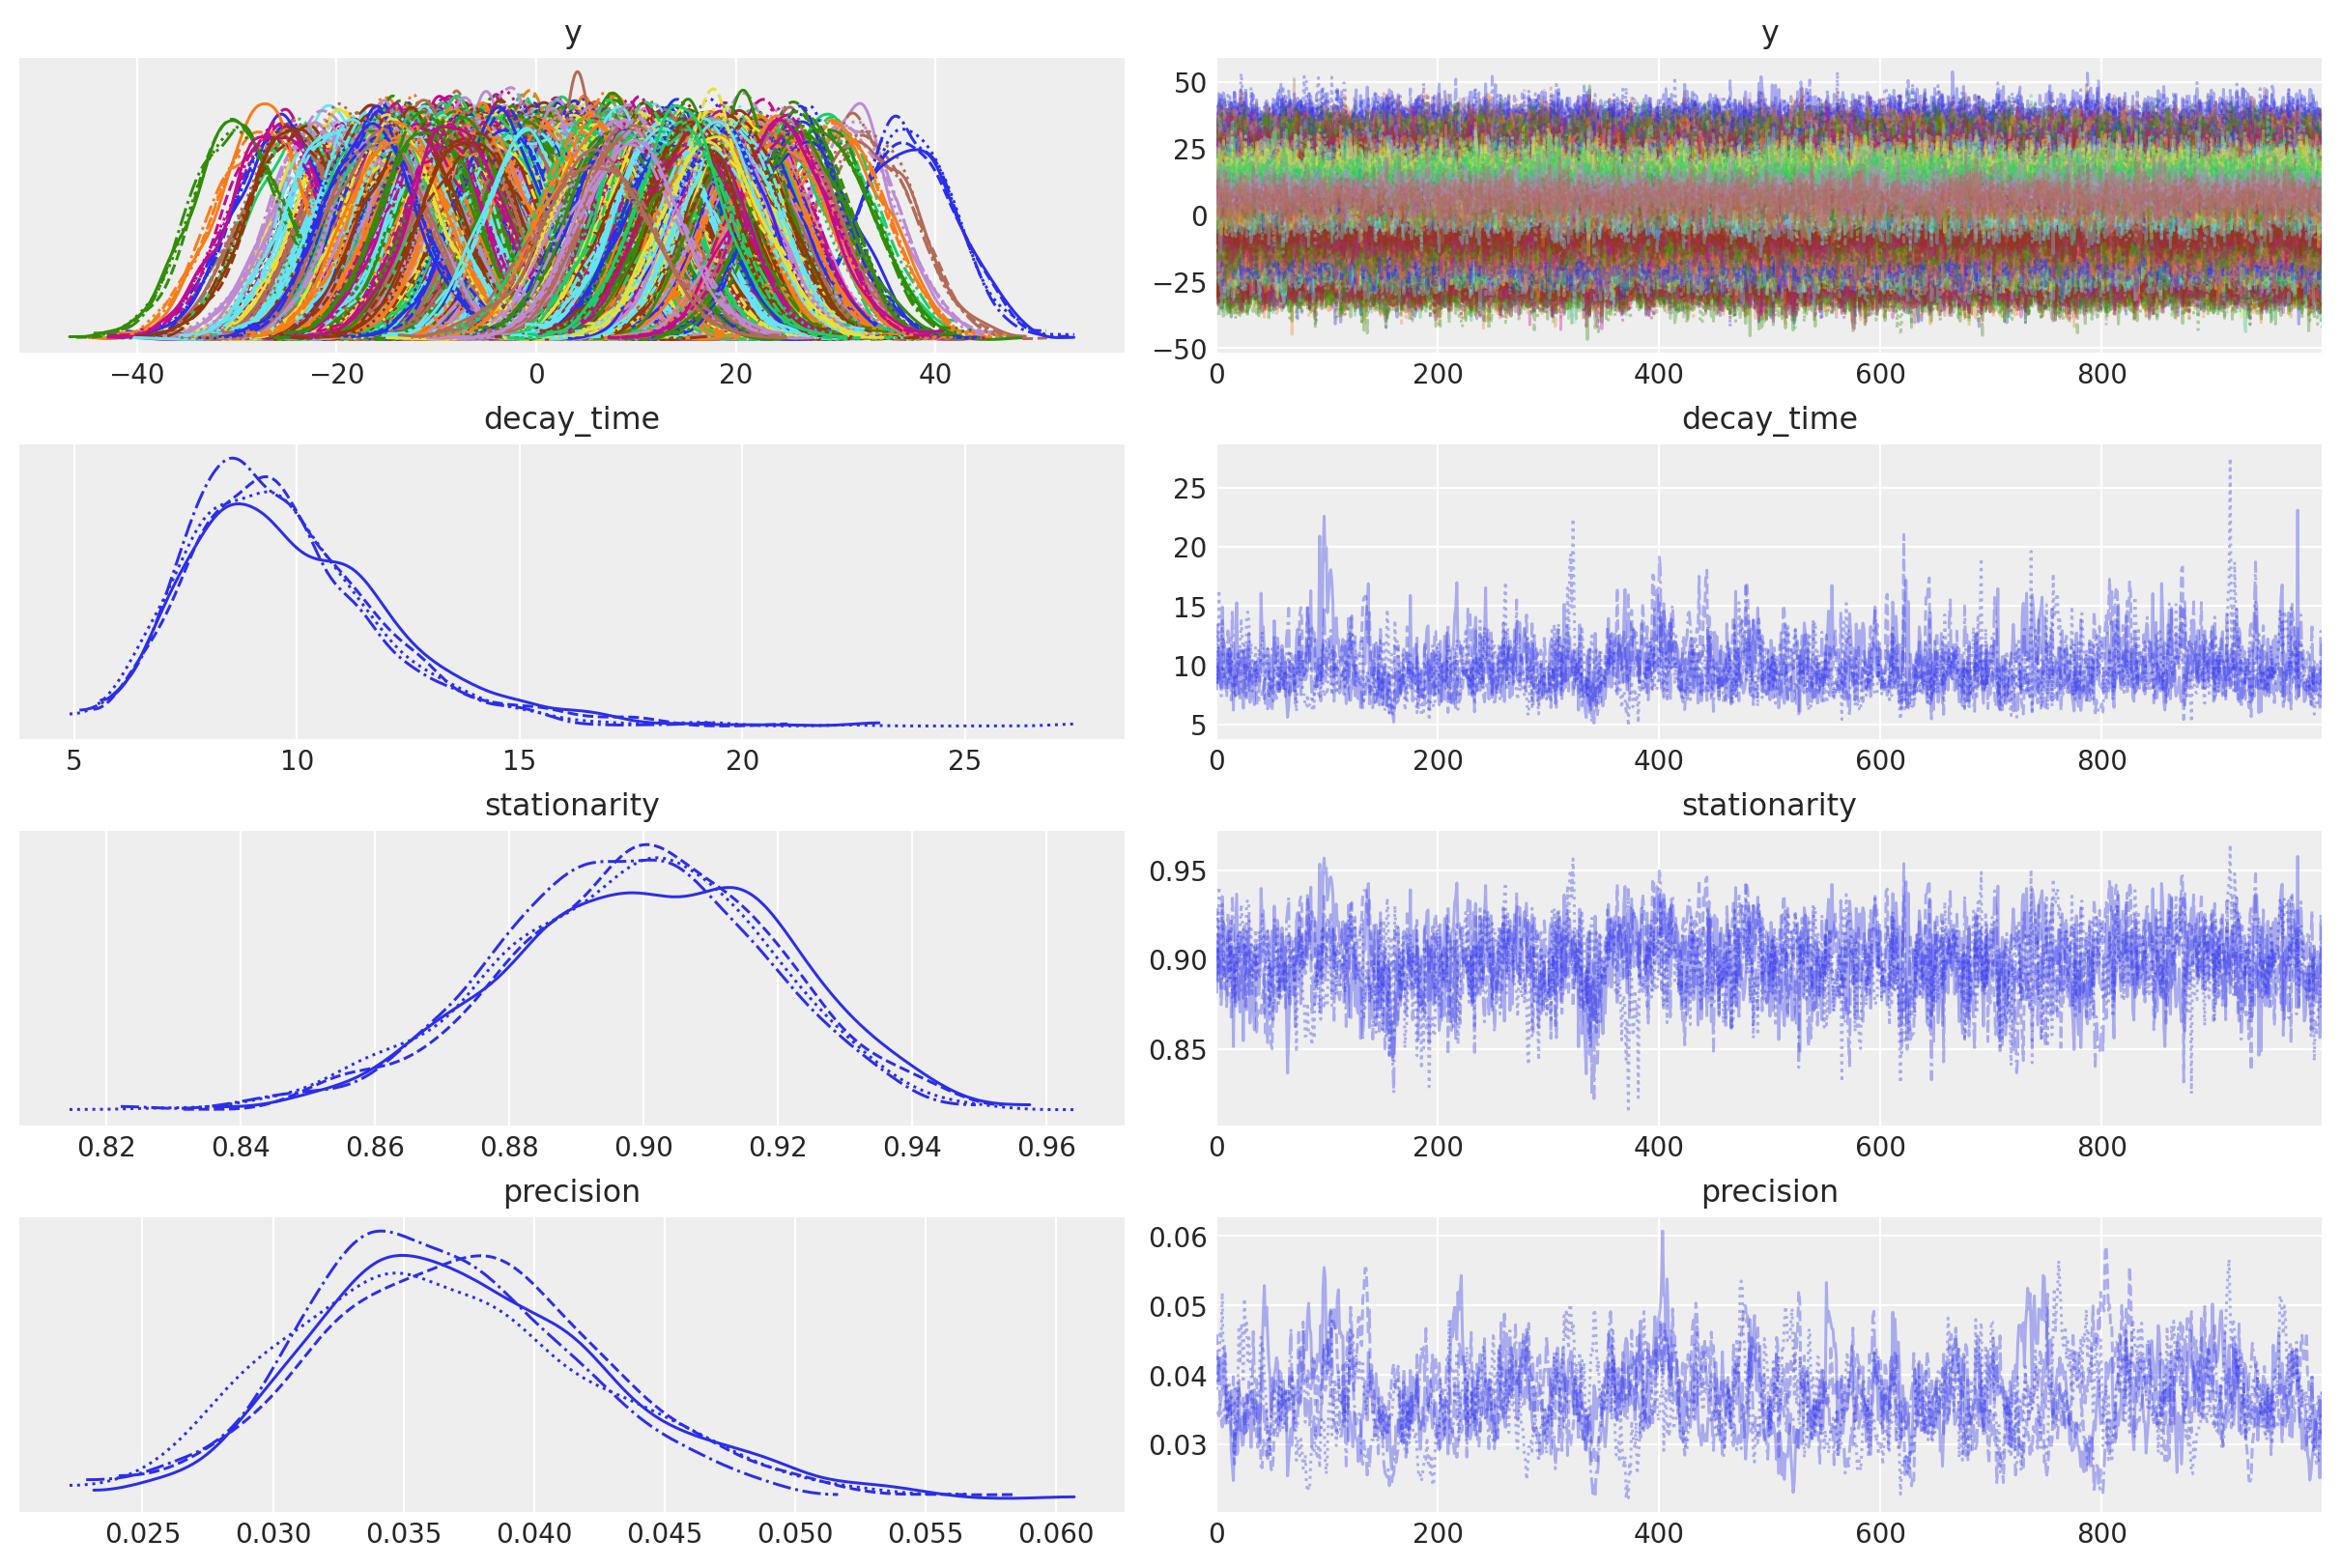

In [12]:
az.plot_trace(
    idata,
    lines=[
        ("decay_time"),
        ("precision"),
    ],
);

About the camera noise, we tried to calculate our overall uncertainty as $\tau_E=\frac{1}{\frac{1}{precisionAR1}+(1-k^2)\sigma_{CameraNoise}^2}$, where $k=e^{-1/\tau}$, $precisonAR1=\frac{1}{\sigma_{e}^2}$. But it is still very far from true values. We will come to office hour for help. :)